# Lab 3 (08.11.19)

## 1. Maximum Likelihood principle

In [11]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
%matplotlib inline 
plt.style.use('seaborn-white')

In [6]:
rng = np.random.RandomState(181) # reproducibility!

# Simulate 1000 coin flips
p = 0.4 # Probability of Heads (Heads is 1)
n = 1000
flips = rng.binomial(1, p, n)

1. Assume that flips was generated from 1000 repeated Bernoulli draws where each draw has probability of Heads equal to $p$. Write down the likelihood function and derive the log-likelihood function.

Likelihood funcion: $\mathcal{L}(y;p) = \prod_{i=1}^{1000}p^{y_i}(1-p)^{1-y_i}$

Log-likelihood function: $\ell(y;p)=\log(p) * \sum_{i=1}^{1000}y_i + \log(1-p) \sum_{i=1}^{1000}1-y_i$

2. Plot the log-likelihood as a function of p.

In [24]:
def log_likelihood(p):
    return np.log(p)*np.sum(flips) + np.log(1-p)*np.sum(1-flips)

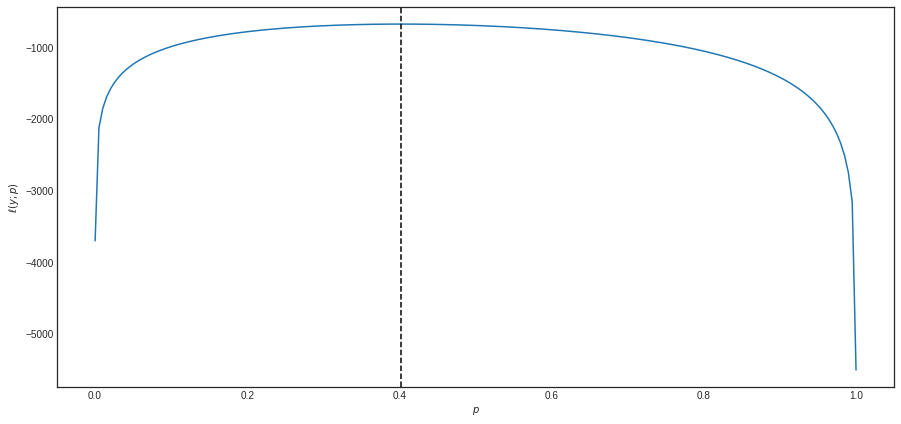

In [113]:
epsilon = 1/10000
ps = np.linspace(0+epsilon,1-epsilon,200)

plt.figure(figsize=(15,7))
plt.plot(ps, list(map(log_likelihood, ps)))
plt.ylabel(r'$\ell(y;p)$')
plt.xlabel(r'$p$')
plt.axvline(x=np.sum(flips)/n, linestyle='--', c='black')
plt.show();

3. Use the optimize function to find the $p^{∗}$ that maximizes the log-likelihood function. (You know how to do this manually using gradient descent or alternatives but in practice if is often easier and safer to rely on routines written for this purpose.)

In [115]:
def neg_log_likelihood(p):
    return -1*(np.log(p)*np.sum(flips) + np.log(1-p)*np.sum(1-flips))

res = minimize_scalar(neg_log_likelihood,
                      bounds=(0+epsilon,1-epsilon), method='bounded')

print(r'$p^{*}=$', res.x)

$p^{*}=$ 0.40199848613126293


Alternatively, we can perform numerical gradient descent. However, we have to make sure that $h$ is small enough such that $p$ does not get too close to 0 or 1 such that the log-likelihood approaches -infinity.

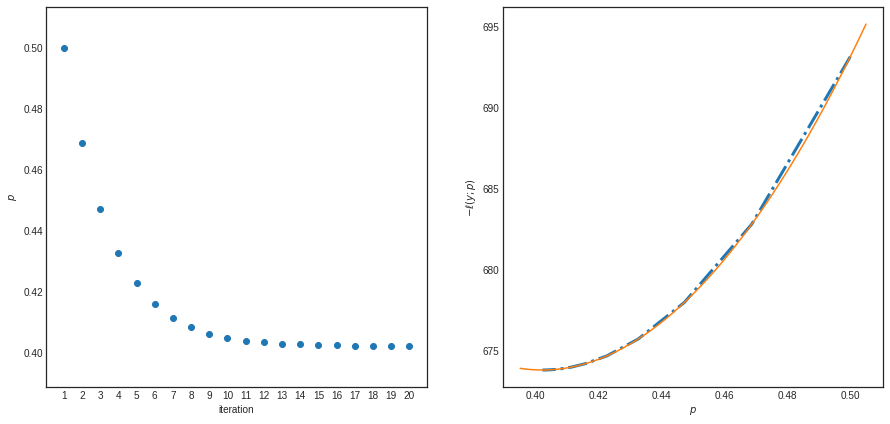

In [118]:
def g_hat(f, p, h):
    return (f(p+h)-f(p-h))/2*h

def update_step_(p, g, lambda_, f, h):
    return p - lambda_*g(f, p, h)

fs = []
ps = []
p = 0.5
steps=20
lambda_=0.8
h = 0.01

for i in range(steps):
    if i==0:
        ps.append(p)
        fs.append(neg_log_likelihood(p))
    else:
        p = update_step_(p, g_hat, lambda_, neg_log_likelihood, h)
        ps.append(p)
        fs.append(neg_log_likelihood(p))
        
domain = np.linspace(0.395, 0.505, 200)
fig, axs = plt.subplots(1, 2, figsize=(15,7)) # Creating fig with 2 col, 1 rows
axs[0].scatter(np.arange(1,steps+1), ps)
axs[0].set_xlabel('iteration')
axs[0].set_xticks(np.arange(1,steps+1))
axs[0].set_ylabel(r'$p$')
axs[1].plot(ps, fs, linestyle='-.', linewidth=3)
axs[1].plot(domain, list(map(neg_log_likelihood, domain)))
axs[1].set_xlabel(r'$p$')
axs[1].set_ylabel(r'$-\ell(y;p)$')
plt.show();

## 2. Generalized linear models

In [120]:
# Import data
path_to_data = '/home/j-a-h/research/ml-course/Lab3_MaximumLikelihood.csv'
df = pd.read_csv(path_to_data, sep=';', index_col=0)

In [125]:
df.head()

,LoanAmount,SectorName,TimeToFund,IndFemale
id,,,,
109819,500,Manufacturing,5,1
1469649,300,Services,8,1
1505147,350,Services,21,1
1685949,200,Housing,2,1
1636050,225,Health,21,0


1. Generate an indicator variable for whether a loan proposal takes at most 14 days to get funded, i.e. generate
$$ Days14 =
  \begin{cases}
    1       & \quad \text{if } TimeToFund\leq 14 \\
    0  & \quad \text{otherwise}
  \end{cases}
$$

In [130]:
df['Days14'] = (df['TimeToFund'] <= 14)*1

In [131]:
df.head()

,LoanAmount,SectorName,TimeToFund,IndFemale,Days14
id,,,,,
109819,500,Manufacturing,5,1,1
1469649,300,Services,8,1,1
1505147,350,Services,21,1,0
1685949,200,Housing,2,1,1
1636050,225,Health,21,0,0


2. Take a look at the glm command and its helpfile. Make sure you understand how to specify the
distribution family and link function. Estimate a logistic regression with logit link to explain Days14
with the two predictors IndF emale, LoanAmount.

In [133]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [135]:
logreg = smf.glm('Days14 ~ IndFemale + LoanAmount',
                data=df,
                family=sm.families.Binomial()).fit()
print(logreg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Days14   No. Observations:                65467
Model:                            GLM   Df Residuals:                    65464
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -37218.
Date:                Wed, 20 Nov 2019   Deviance:                       74436.
Time:                        14:34:10   Pearson chi2:                 6.48e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0570      0.022     47.720      0.0

3. Interpret the coefficient on IndFemale.

4. Now estimate a Poisson regression for the outcome TimeToFund using the same two predictor
variables. Estimate the regression once with a log link and once with an identity link. In each case,
interpret the coefficient on IndFemale.

In [140]:
poireg = smf.glm('TimeToFund ~ IndFemale + LoanAmount',
                data=df,
                family=sm.families.Poisson()).fit()
print(poireg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             TimeToFund   No. Observations:                65467
Model:                            GLM   Df Residuals:                    65464
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.2107e+05
Date:                Wed, 20 Nov 2019   Deviance:                   5.9916e+05
Time:                        14:40:03   Pearson chi2:                 6.40e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3954      0.003    867.565      0.0

In [167]:
ident = sm.families.links.identity()
poireg_id = smf.glm('TimeToFund ~ IndFemale + LoanAmount',
                data=df,
                family=sm.families.Poisson(link=ident)).fit()
print(poireg_id.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             TimeToFund   No. Observations:                65467
Model:                            GLM   Df Residuals:                    65464
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.1594e+05
Date:                Wed, 20 Nov 2019   Deviance:                   5.8891e+05
Time:                        14:57:12   Pearson chi2:                 6.30e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8704      0.038    261.094      0.0

/home/j-a-h/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


5. You would like to add the variable SectorName, a categorical variable with 15 levels, to your model
but you are concerned that your model would use too many variables and might overfit in that case.
How would you amend the likelihood function to guard against this risk? (Note: This is a conceptual
question, not a coding question)

6. Take a look at the glmnet package and run the poisson regression with log-link from above using a
LASSO penalty for a sequence of weights λ on the penalty part of the objective function. (Note:
glmnet with Poisson regression uses a log-link by default.)

In [173]:
poireg = smf.glm('TimeToFund ~ IndFemale + LoanAmount',
                data=df,
                family=sm.families.Poisson()).fit_regularized(method='elastic_net', alpha=0.5, L1_wt=1)
#print(poireg.summary())

In [180]:
beta_1 = []
beta_2 = []
alphas = np.linspace(0,1,200)

for alpha in alphas:
    poireg = smf.glm('TimeToFund ~ IndFemale + LoanAmount',
                    data=df,
                    family=sm.families.Poisson()
                    ).fit_regularized(alpha=alpha, L1_wt=1)
    beta_1.append(poireg.params[1])
    beta_2.append(poireg.params[2])

7. Plot your coefficients as a function of λ.

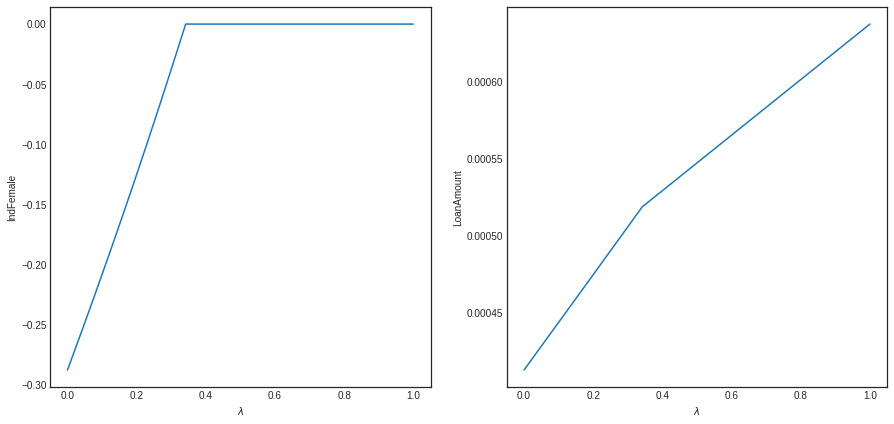

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(15,7)) # Creating fig with 2 col, 1 rows
axs[0].plot(alphas, beta_1)
axs[0].set_ylabel('IndFemale')
axs[1].plot(alphas, beta_2)
axs[1].set_ylabel('LoanAmount')
for ax in axs:
    ax.set_xlabel(r'$\lambda$')